In [1]:
import torch
import open_clip
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset as PTConcatDataset
from tqdm.notebook import tqdm
from scipy.stats import entropy
from IPython.display import display
import seaborn as sns
import os
import bisect

from rtpt.rtpt import setproctitle
setproctitle('@Clipping_Privacy_LAION400M_Notebook')
os.chdir('/workspace')

from datasets import FaceScrub, SingleClassSubset

%matplotlib inline

pd.set_option('display.max_rows', 15)

# Prepare the CLIP model

In [2]:
# init clip
device = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAMES = ['ViT-B-32', 'ViT-B-16', 'ViT-L-14']
models = {}
preprocessings = {}
for model_name in MODEL_NAMES:
    model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained='laion400m_e32')
    preprocessings[model_name] = preprocess
    model = model.eval()
    models[model_name] = model

100%|███████████████████████████████████████| 605M/605M [00:38<00:00, 15.7MiB/s]
100%|███████████████████████████████████████| 599M/599M [00:58<00:00, 10.2MiB/s]
100%|█████████████████████████████████████| 1.71G/1.71G [02:16<00:00, 12.5MiB/s]


# Load the Members and Non-Members

In [3]:
laion_non_members = pd.read_csv('./laion400m_experiments/laion400m_non_members.csv', index_col=0).reset_index(drop=True).drop(['False', 'True'], axis='columns')

laion_non_members['name'] = laion_non_members['class_name'].apply(lambda x: x.replace("_", " "))
print('Non-Members')
display(laion_non_members)

laion_members = pd.read_csv('./laion400m_experiments/laion400m_members.csv', index_col=0).reset_index(drop=True).drop(['False', 'True'], axis='columns')
laion_members['name'] = laion_members['class_name'].apply(lambda x: x.replace("_", " "))
display(laion_members)

Non-Members


,class_name,name
0,Jenilee_Harrison,Jenilee Harrison
1,Jessica_Leccia,Jessica Leccia
2,Mackenzie_Aladjem,Mackenzie Aladjem
3,Annette_Frier,Annette Frier
4,Barbara_Schöneberger,Barbara Schöneberger
...,...,...
13,Kai_Pflaume,Kai Pflaume
14,Max_Giermann,Max Giermann
15,Michael_Kessler,Michael Kessler
16,Sabine_Vitua,Sabine Vitua


,class_name,name
0,Aaron_Eckhart,Aaron Eckhart
1,Adam_Brody,Adam Brody
2,Adam_Sandler,Adam Sandler
3,Adrien_Brody,Adrien Brody
4,Adrienne_Barbeau,Adrienne Barbeau
...,...,...
500,Wendie_Malick,Wendie Malick
501,Woody_Allen,Woody Allen
502,Yasmine_Bleeth,Yasmine Bleeth
503,Zooey_Deschanel,Zooey Deschanel


# Define the FaceScrub Dataset Class

In [4]:
class ConcatDataset(PTConcatDataset):
    @property
    def classes(self):
        classes = []
        for dataset in self.datasets:
            classes.extend(dataset.classes)

        return classes

    @property
    def targets(self):
        targets = []
        for i, dataset in enumerate(self.datasets):
            max_target = sum([len(self.datasets[i].classes) for i in range(0, i)])
            targets.extend((np.array(dataset.targets) + max_target).tolist())
        
        return targets

    def __getitem__(self, idx):
        if idx < 0:
            if -idx > len(self):
                raise ValueError("absolute value of index should not exceed dataset length")
            idx = len(self) + idx
        dataset_idx = bisect.bisect_right(self.cumulative_sizes, idx)
        if dataset_idx == 0:
            sample_idx = idx
        else:
            sample_idx = idx - self.cumulative_sizes[dataset_idx - 1]

        x, y = self.datasets[dataset_idx][sample_idx]

        max_target = sum([len(self.datasets[i].classes) for i in range(0, dataset_idx)])

        return x, y + max_target

In [5]:
facescrub_datasets = {model_name: FaceScrub(root='./data/facescrub', group='all', train=True, cropped=False, transform=preprocess) for model_name in MODEL_NAMES}
laion_german_non_members_actors = {model_name: ImageFolder('./data/laion_german_non_members/actors/images', transform=preprocess) for model_name in MODEL_NAMES}
laion_german_non_members_actresses = {model_name: ImageFolder('./data/laion_german_non_members/actresses/images', transform=preprocess) for model_name in MODEL_NAMES}

In [6]:
concat_datasets = {model_name: ConcatDataset([facescrub_datasets[model_name], laion_german_non_members_actors[model_name], laion_german_non_members_actresses[model_name]]) for model_name in MODEL_NAMES}

In [7]:
for model_name in MODEL_NAMES:
    print(f'---------- {model_name} ----------')
    print(f'Dataset size: {len(concat_datasets[model_name])}')
    print(f'First Few Classes: {concat_datasets[model_name].classes[:10]}')
    print(f'Last Few Classes: {concat_datasets[model_name].classes[-10:]}')
    print(f'Total Number of Classes: {len(concat_datasets[model_name].classes)}')

---------- ViT-B-32 ----------
Dataset size: 38204
First Few Classes: ['Aaron_Eckhart', 'Adam_Brody', 'Adam_McKay', 'Adam_Sandler', 'Adrien_Brody', 'Al_Pacino', 'Alan_Alda', 'Alan_Arkin', 'Alan_Rickman', 'Alec_Baldwin']
Last Few Classes: ['Max_Giermann', 'Michael_Kessler', 'Alice_Dwyer', 'Annette_Frier', 'Barbara_Schöneberger', 'Bettina_Lamprecht', 'Carolin_Kebekus', 'Friederike_Linke', 'Sabine_Vitua', 'Sonsee_Neu']
Total Number of Classes: 546
---------- ViT-B-16 ----------
Dataset size: 38204
First Few Classes: ['Aaron_Eckhart', 'Adam_Brody', 'Adam_McKay', 'Adam_Sandler', 'Adrien_Brody', 'Al_Pacino', 'Alan_Alda', 'Alan_Arkin', 'Alan_Rickman', 'Alec_Baldwin']
Last Few Classes: ['Max_Giermann', 'Michael_Kessler', 'Alice_Dwyer', 'Annette_Frier', 'Barbara_Schöneberger', 'Bettina_Lamprecht', 'Carolin_Kebekus', 'Friederike_Linke', 'Sabine_Vitua', 'Sonsee_Neu']
Total Number of Classes: 546
---------- ViT-L-14 ----------
Dataset size: 38204
First Few Classes: ['Aaron_Eckhart', 'Adam_Brody', 

In [8]:
dataset_class_subset_per_model = {}
for model_name in MODEL_NAMES:
    dataset_class_subsets = []
    for class_idx in range(len(concat_datasets[model_name].classes)):
        dataset_class_subsets.append(SingleClassSubset(concat_datasets[model_name], class_idx))
    dataset_class_subset_per_model[model_name] = dataset_class_subsets

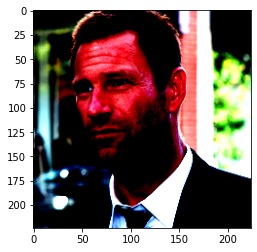

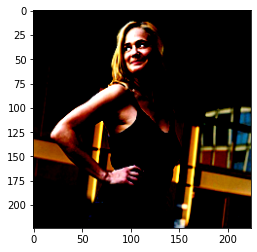

In [9]:
# visualize the first and last preprocessed image of the first class
plt.imshow(dataset_class_subset_per_model[MODEL_NAMES[0]][0][0][0].permute(1,2,0).numpy())
plt.show()
plt.imshow(dataset_class_subset_per_model[MODEL_NAMES[0]][-1][0][0].permute(1,2,0).numpy())
plt.show()

# Run the Model for Test Purposes on the first Actor

In [10]:
# get the context vector of the possible labels
split_class_names = {model_name: [x.replace("_", " ") for x in concat_datasets[model_name].classes] for model_name in MODEL_NAMES}
label_context_vecs = {model_name: open_clip.tokenize(split_class_names[model_name]) for model_name in MODEL_NAMES}

In [11]:
split_class_names[MODEL_NAMES[0]][-20:]

['Wanda De Jesus',
 'Wendie Malick',
 'Yasmine Bleeth',
 'Zooey Deschanel',
 'Bastian Pastewka',
 'Bernhard Hoëcker',
 'Guido Cantz',
 'Johannes B. Kerner',
 'Jörg Pilawa',
 'Kai Pflaume',
 'Max Giermann',
 'Michael Kessler',
 'Alice Dwyer',
 'Annette Frier',
 'Barbara Schöneberger',
 'Bettina Lamprecht',
 'Carolin Kebekus',
 'Friederike Linke',
 'Sabine Vitua',
 'Sonsee Neu']

In [12]:
# define a function to get the predictions for an actor/actress
@torch.no_grad()
def get_preds_for_dataset(model, subset, context, batch_size=8, num_workers=8, device=device):
    datalaoder = DataLoader(subset, batch_size=batch_size, num_workers=num_workers, pin_memory=device == 'cuda')
    
    context = context.to(device)
    model = model.to(device)

    preds = []
    for x, _ in tqdm(datalaoder, desc='Iterating Dataset'):
        x = x.to(device)
        image_features, text_features, logits_scale = model(x, context)
        # we have to calculate the cosine similarity manually. OpenAI does this internally.
        logits_per_image = logits_scale  * image_features @ text_features.T
        preds.append(logits_per_image.argmax(-1).cpu())

    model = model.cpu()
    context = context.cpu()
    return torch.cat(preds)


In [13]:
test_subset_dataset = dataset_class_subset_per_model[MODEL_NAMES[0]][3]
unique_vals, counts = get_preds_for_dataset(models[MODEL_NAMES[0]], test_subset_dataset, label_context_vecs[MODEL_NAMES[0]]).unique(return_counts=True)
prediction = unique_vals[counts.argmax()]
print(f'Prediction: {concat_datasets[MODEL_NAMES[0]].classes[prediction]}\t Correct Class: {concat_datasets[MODEL_NAMES[0]].classes[test_subset_dataset.target_class]}')

Iterating Dataset:   0%|          | 0/9 [00:00<?, ?it/s]

Prediction: Adam_Sandler	 Correct Class: Adam_Sandler


In [14]:
test_subset_dataset = dataset_class_subset_per_model[MODEL_NAMES[0]][-3]
unique_vals, counts = get_preds_for_dataset(models[MODEL_NAMES[0]], test_subset_dataset, label_context_vecs[MODEL_NAMES[0]]).unique(return_counts=True)
prediction = unique_vals[counts.argmax()]
print(f'Prediction: {concat_datasets[MODEL_NAMES[0]].classes[prediction]}\t Correct Class: {concat_datasets[MODEL_NAMES[0]].classes[test_subset_dataset.target_class]}')

Iterating Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

Prediction: Lecy_Goranson	 Correct Class: Friederike_Linke


# Run the CLIP model on each Actress/Actor

In [15]:
preds_per_model = {}
for model_name in MODEL_NAMES:
    dataset = PTConcatDataset(dataset_class_subset_per_model[model_name])
    print(f'{model_name}:')
    preds = get_preds_for_dataset(models[model_name], dataset, label_context_vecs[model_name], batch_size=256, num_workers=64)
    assert len(preds) == len(dataset)
    preds_per_model[model_name] = preds

ViT-B-32:


Iterating Dataset:   0%|          | 0/150 [00:00<?, ?it/s]

/opt/conda/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


ViT-B-16:


Iterating Dataset:   0%|          | 0/150 [00:00<?, ?it/s]

/opt/conda/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


ViT-L-14:


Iterating Dataset:   0%|          | 0/150 [00:00<?, ?it/s]

/opt/conda/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


In [16]:
# split the large list of all predictions into prediction lists for every class
preds_per_model_per_subset = {}
for model_name, preds in preds_per_model.items():
    preds_per_subset = []
    counter = 0
    for subset in dataset_class_subset_per_model[model_name]:
        preds_per_subset.append(preds[counter:counter + len(subset)])
        counter += len(subset)
    preds_per_model_per_subset[model_name] = preds_per_subset

In [17]:
preds_df_per_model = {}
for model_name in models.keys():
    df_list = []
    for group_idx, (dataset_subset, preds_subset) in enumerate(zip(dataset_class_subsets, preds_per_model_per_subset[model_name])):
        for sample_idx, pred in enumerate(preds_subset):
            class_name = concat_datasets[model_name].classes[dataset_class_subsets[group_idx].target_class]
            df_list.append({
                'group_idx': group_idx,
                'class_name': class_name,
                'sample_idx': sample_idx,
                'prediction': concat_datasets[model_name].classes[int(pred)]
            })
    preds_df = pd.DataFrame(df_list)
    preds_df_per_model[model_name] = preds_df

In [18]:
preds_df_per_model[model_name]

,group_idx,class_name,sample_idx,prediction
0,0,Aaron_Eckhart,0,Aaron_Eckhart
1,0,Aaron_Eckhart,1,Aaron_Eckhart
2,0,Aaron_Eckhart,2,Aaron_Eckhart
3,0,Aaron_Eckhart,3,Aaron_Eckhart
4,0,Aaron_Eckhart,4,Aaron_Eckhart
...,...,...,...,...
38199,545,Sonsee_Neu,25,Alice_Krige
38200,545,Sonsee_Neu,26,Carolin_Kebekus
38201,545,Sonsee_Neu,27,Julie_Marie_Berman
38202,545,Sonsee_Neu,28,Dina_Meyer


In [20]:
# determine the actual membership of the samples
for model_name, preds_df in preds_df_per_model.items():
    members = pd.merge(preds_df, laion_members['class_name'], on='class_name')
    members['actual_membership'] = 'member'
    non_members = pd.merge(preds_df, laion_non_members['class_name'], on='class_name')
    non_members['actual_membership'] = 'non_member'
    preds_df_per_model[model_name] = pd.concat([members, non_members]).reset_index(drop=True)

preds_df_per_model[model_name]

,group_idx,class_name,sample_idx,prediction,actual_membership
0,0,Aaron_Eckhart,0,Aaron_Eckhart,member
1,0,Aaron_Eckhart,1,Aaron_Eckhart,member
2,0,Aaron_Eckhart,2,Aaron_Eckhart,member
3,0,Aaron_Eckhart,3,Aaron_Eckhart,member
4,0,Aaron_Eckhart,4,Aaron_Eckhart,member
...,...,...,...,...,...
37678,545,Sonsee_Neu,25,Alice_Krige,non_member
37679,545,Sonsee_Neu,26,Carolin_Kebekus,non_member
37680,545,Sonsee_Neu,27,Julie_Marie_Berman,non_member
37681,545,Sonsee_Neu,28,Dina_Meyer,non_member


In [21]:
preds_df_per_model['ViT-B-32'].groupby('class_name').sample(2).head(10)

,group_idx,class_name,sample_idx,prediction,actual_membership
65,0,Aaron_Eckhart,65,Aaron_Eckhart,member
12,0,Aaron_Eckhart,12,Aaron_Eckhart,member
157,1,Adam_Brody,66,Chris_Klein,member
160,1,Adam_Brody,69,Jackson_Rathbone,member
193,3,Adam_Sandler,7,Adam_Sandler,member
219,3,Adam_Sandler,33,Adam_Sandler,member
318,4,Adrien_Brody,60,David_Schwimmer,member
281,4,Adrien_Brody,23,Adrien_Brody,member
19997,266,Adrienne_Barbeau,28,Sara_Gilbert,member
19992,266,Adrienne_Barbeau,23,Adrienne_Barbeau,member


In [20]:
len(preds_df_per_model[model_name].groupby('class_name'))

523

In [21]:
subsample_sizes_per_model = {}
for model_name, preds_df in preds_df_per_model.items():
    min_num_images = preds_df.value_counts('class_name').sort_values()[0]
    subsample_sizes = np.arange(0, min_num_images+1, 2).tolist()
    subsample_sizes[0] = 1
    subsample_sizes_per_model[model_name] = subsample_sizes

In [22]:
subsampled_dfs_per_model = {}
sample_draws = 20
for model_name, preds_df in preds_df_per_model.items():
    subsample_sizes = subsample_sizes_per_model[model_name]
    subsampled_dfs = []
    for sample_size in tqdm(subsample_sizes):
        for i in range(sample_draws):
            membership_prediction_df = preds_df.groupby('class_name').sample(sample_size).groupby('class_name')['prediction'].agg(pd.Series.mode).apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else [x]).reset_index()
            membership_prediction_df['membership_prediction'] = membership_prediction_df.apply(lambda x: 'member' if len(x['prediction']) == 1 and x['class_name'] in x['prediction'] else 'non_member', axis='columns')
            membership_prediction_df = pd.merge(membership_prediction_df, preds_df[['class_name', 'actual_membership']].groupby('class_name')['actual_membership'].agg(pd.Series.mode), on='class_name')
            num_member, num_non_member = membership_prediction_df['actual_membership'].value_counts()['member'], membership_prediction_df['actual_membership'].value_counts()['non_member']

            tp = len(membership_prediction_df[(membership_prediction_df['membership_prediction'] == 'member') & (membership_prediction_df['actual_membership'] == 'member')])
            fp = len(membership_prediction_df[(membership_prediction_df['membership_prediction'] == 'member') & (membership_prediction_df['actual_membership'] == 'non_member')])
            fn = len(membership_prediction_df[(membership_prediction_df['membership_prediction'] == 'non_member') & (membership_prediction_df['actual_membership'] == 'member')])
            tn = len(membership_prediction_df[(membership_prediction_df['membership_prediction'] == 'non_member') & (membership_prediction_df['actual_membership'] == 'non_member')])

            subsampled_dfs.append({
                'sample_size': sample_size,
                'draw': i,
                'tpr': tp / num_member,
                'fnr': fn / num_member,
                'fpr': fp / num_non_member,
                'tnr': tn / num_non_member,
                'tp': tp,
                'fn': fn,
                'fp': fp,
                'tn': tn
            })
    subsampled_dfs_per_model[model_name] = subsampled_dfs

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [23]:
for model_name, subsampled_dfs in subsampled_dfs_per_model.items():
    subsampled_dfs_per_model[model_name] = pd.DataFrame(subsampled_dfs_per_model[model_name]).set_index('sample_size').drop('draw', axis='columns')
    subsampled_dfs_per_model[model_name] = subsampled_dfs_per_model[model_name].rename(columns={'tpr': 'True Positive Rate', 'fnr': 'False Negative Rate', 'fpr': 'False Positive Rate', 'tnr': 'True Negative Rate'})
    subsampled_dfs_per_model[model_name].index.name = 'Number of Samples'

In [24]:
subsampled_dfs_per_model['ViT-B-32']

,True Positive Rate,False Negative Rate,False Positive Rate,True Negative Rate,tp,fn,fp,tn
Number of Samples,,,,,,,,
1,0.661386,0.338614,0.055556,0.944444,334,171,1,17
1,0.641584,0.358416,0.111111,0.888889,324,181,2,16
1,0.651485,0.348515,0.055556,0.944444,329,176,1,17
1,0.635644,0.364356,0.111111,0.888889,321,184,2,16
1,0.641584,0.358416,0.111111,0.888889,324,181,2,16
...,...,...,...,...,...,...,...,...
30,0.922772,0.077228,0.000000,1.000000,466,39,0,18
30,0.920792,0.079208,0.000000,1.000000,465,40,0,18
30,0.924752,0.075248,0.000000,1.000000,467,38,0,18


In [30]:
# TODO: uncomment this if you run the notebook for the first time to store the predictions to a file
# for model_name, subsampled_dfs in subsampled_dfs_per_model.items():
#     subsampled_dfs.to_csv(f'laion400m_experiments/prediction_dfs/predictions_laion_{model_name}.csv')
subsampled_dfs_per_model = {}
for model_name, _ in models.items():
    subsampled_dfs_per_model[model_name] = pd.read_csv(f'laion400m_experiments/prediction_dfs/predictions_laion_{model_name}.csv', index_col=0)

In [31]:
for num_members, df in subsampled_dfs_per_model.items():
    display(df.tail(3))

,True Positive Rate,False Negative Rate,False Positive Rate,True Negative Rate,tp,fn,fp,tn
Number of Samples,,,,,,,,
30,0.924752,0.075248,0.0,1.0,467,38,0,18
30,0.914851,0.085149,0.0,1.0,462,43,0,18
30,0.920792,0.079208,0.0,1.0,465,40,0,18


,True Positive Rate,False Negative Rate,False Positive Rate,True Negative Rate,tp,fn,fp,tn
Number of Samples,,,,,,,,
30,0.938614,0.061386,0.055556,0.944444,474,31,1,17
30,0.942574,0.057426,0.055556,0.944444,476,29,1,17
30,0.938614,0.061386,0.055556,0.944444,474,31,1,17


,True Positive Rate,False Negative Rate,False Positive Rate,True Negative Rate,tp,fn,fp,tn
Number of Samples,,,,,,,,
30,0.954455,0.045545,0.222222,0.777778,482,23,4,14
30,0.948515,0.051485,0.222222,0.777778,479,26,4,14
30,0.956436,0.043564,0.222222,0.777778,483,22,4,14


ViT-B-32


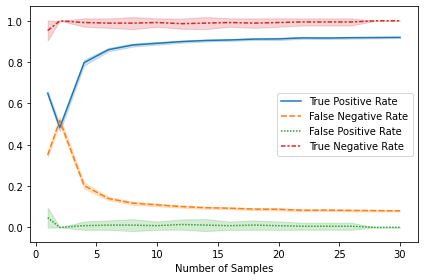

ViT-B-16


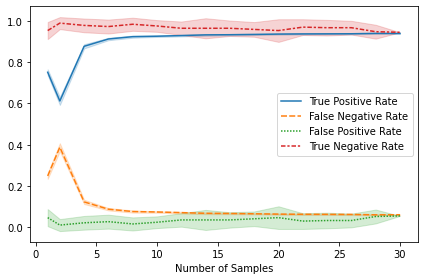

ViT-L-14


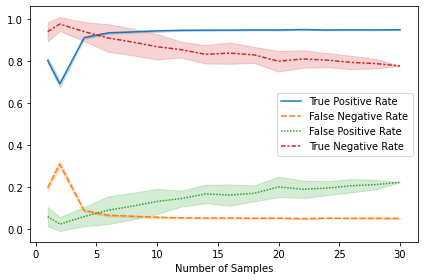

In [32]:
for model_name, subsampled_dfs in subsampled_dfs_per_model.items():
    plt.clf()
    ax = sns.lineplot(data=subsampled_dfs[['True Positive Rate', 'False Negative Rate', 'False Positive Rate', 'True Negative Rate']], ci='sd')
    plt.tight_layout()
    ax.get_figure().savefig(f'./laion400m_experiments/plots/subsample_plot_LAION400M_{model_name}.pdf')
    ax.get_figure().savefig(f'./laion400m_experiments/plots/subsample_plot_LAION400M_{model_name}.png', dpi=100)
    print(model_name)
    plt.show()

ViT-B-32


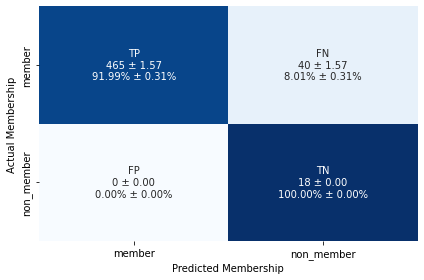

ViT-B-16


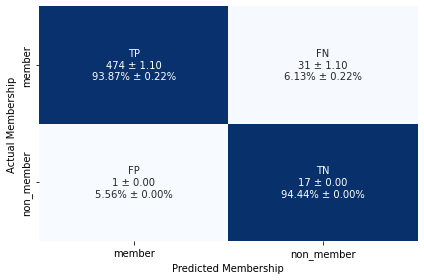

ViT-L-14


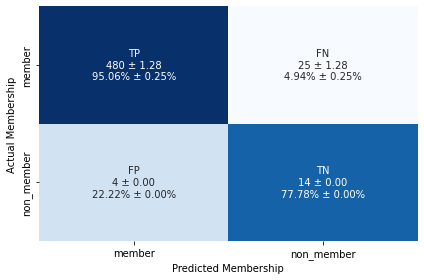

In [33]:
for model_name, subsampled_dfs in subsampled_dfs_per_model.items():
    tp_std, fn_std, fp_std, tn_std = subsampled_dfs.groupby('Number of Samples').std().iloc[-1][['tp', 'fn', 'fp', 'tn']]
    tp, fn, fp, tn = subsampled_dfs.groupby('Number of Samples').mean().iloc[-1][['tp', 'fn', 'fp', 'tn']]

    tpr_std, fnr_std, fpr_std, tnr_std = subsampled_dfs.groupby('Number of Samples').std().iloc[-1][['True Positive Rate', 'False Negative Rate', 'False Positive Rate', 'True Negative Rate']]
    tpr, fnr, fpr, tnr = subsampled_dfs.groupby('Number of Samples').mean().iloc[-1][['True Positive Rate', 'False Negative Rate', 'False Positive Rate', 'True Negative Rate']]

    normalized_conf_mat = pd.DataFrame({'member': [tpr, fpr], 'non_member': [fnr, tnr]}, index=['member', 'non_member'])
    normalized_conf_mat.index.set_names('Actual Membership', inplace=True)
    normalized_conf_mat = normalized_conf_mat.rename_axis('Predicted Membership', axis='columns')

    group_names = ['TP','FN','FP','TN']
    group_counts = ["{0:0.0f} \u00B1 {1:0.2f}".format(mean, std) for mean, std in zip([tp, fn, fp, tn], [tp_std, fn_std, fp_std, tn_std])]
    percentage = ["{0:0.2f}% \u00B1 {1:0.02f}%".format(mean * 100, std * 100) for mean, std in zip([tpr, fnr, fpr, tnr], [tpr_std, fnr_std, fpr_std, tnr_std])]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, percentage)]
    plt.clf()
    ax = sns.heatmap(normalized_conf_mat, annot=np.asarray(labels).reshape(2, 2), fmt='', cbar=False, cmap='Blues')
    plt.tight_layout()
    ax.get_figure().savefig(f'./laion400m_experiments/plots/confusion_matrix_LAION400M_{model_name}.pdf')
    ax.get_figure().savefig(f'./laion400m_experiments/plots/confusion_matrix_LAION400M_{model_name}.png', dpi=100)
    print(model_name)
    plt.show()